In [1]:
from sentence_transformers import SentenceTransformer
from pypdf import PdfReader
import numpy as np
# graph the vectors and their cosine similarities
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch

In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
# Load the PDF
pdf = PdfReader('ExampleRFPs/GoodFit/IETSS DRAFT PWS v2 for RFI FINAL to POST.pdf')
# Extract the text
proposal_content = []
for page in pdf.pages:
    proposal_content.append(page.extract_text())
# split the text into chunks paragraphs for each page
proposal_content = "".join(proposal_content)
# Split the content into paragraphs by empty newlines
paragraphs = [p.strip() for p in proposal_content.split('\n ') if p.startswith('\n') and p.endswith(' ')]
# Filter out any strings that are too short to be considered paragraphs
paragraphs = [p for p in paragraphs if len(p.split()) > 10]  # Adjust the threshold as needed
# Check if we have any paragraphs
if not paragraphs:
    raise ValueError("No valid paragraphs found in the PDF content.")
paragraphs

['Page 2 of 52 \nContents \n1.0 BACKGROUND ................................................................................................................ 4 \n1.1 OIT IV&V TMO and TC & EHRM-IO Integrated Testing FUNCTIONAL AREAS .... 7 \n1.1.1 Test Management and Operations ............................................................................ 7 \n1.1.1.1 Operations and Management .................................................................................... 7 \n1.1.1.2 Test and Evaluation ................................................................................................... 7 \n1.1.1.3 Testing Technology Support ..................................................................................... 8 \n1.1.1.4 Test Process and Quality Management ..................................................................... 8 \n1.1.2 Test Center ................................................................................................................ 8 \n1.1.2.1 Te

In [6]:
queries = [
    "which section is about the objective?",
    "which section is about the background?",
    "which section is about the work scope?",
    "which section is about the schedule?",
    "which section is about the location?",
]
# Encode all documents and querys
doc_embeddings = model.encode(paragraphs)

This code generates a graph of the query similarity between the top 5 results as text embeddings.

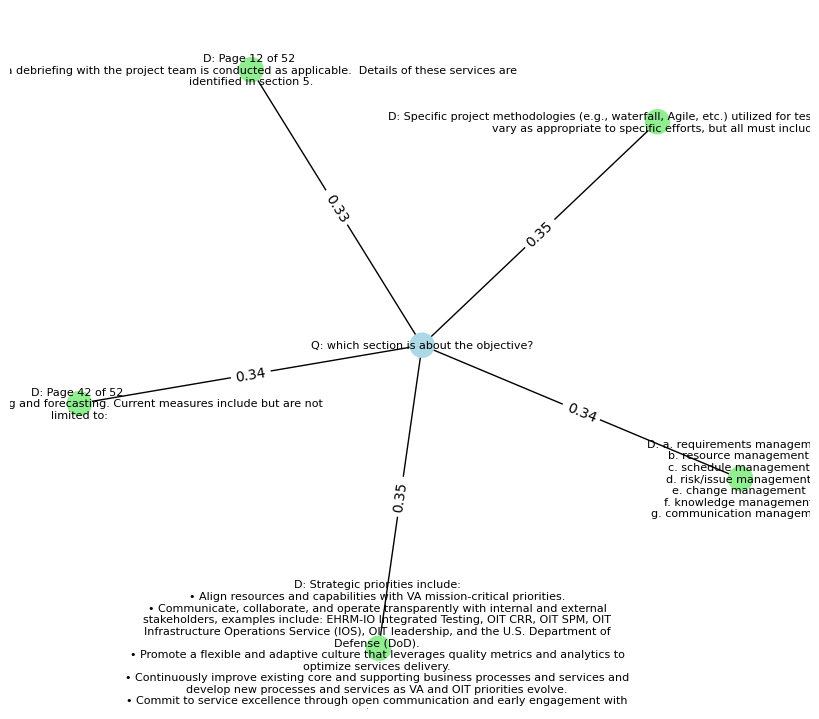

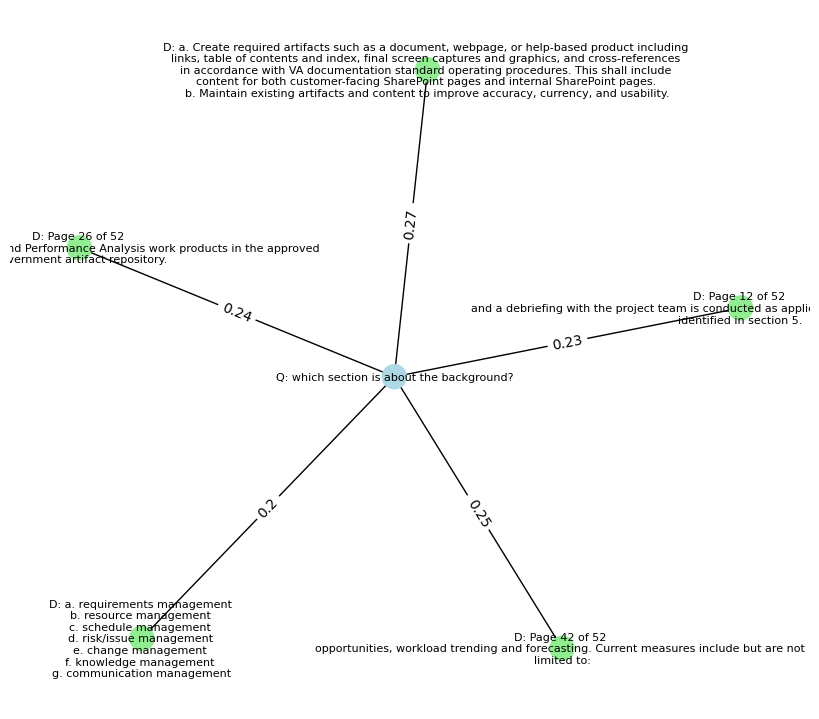

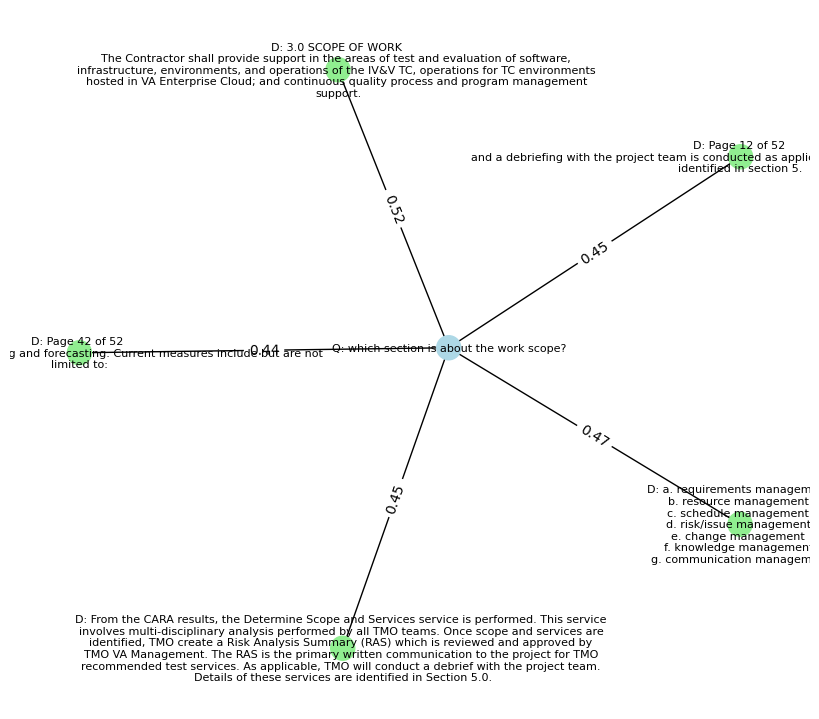

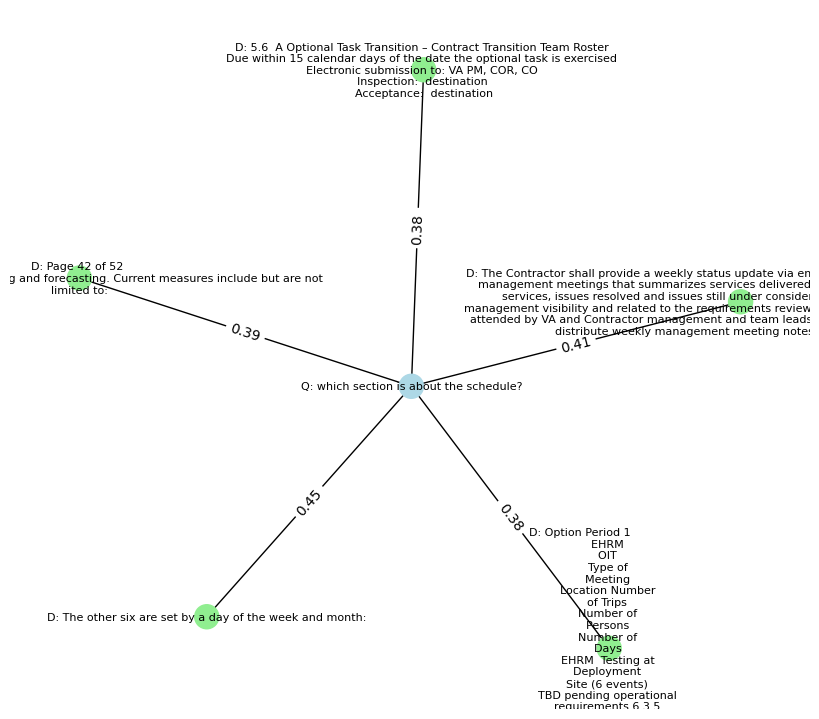

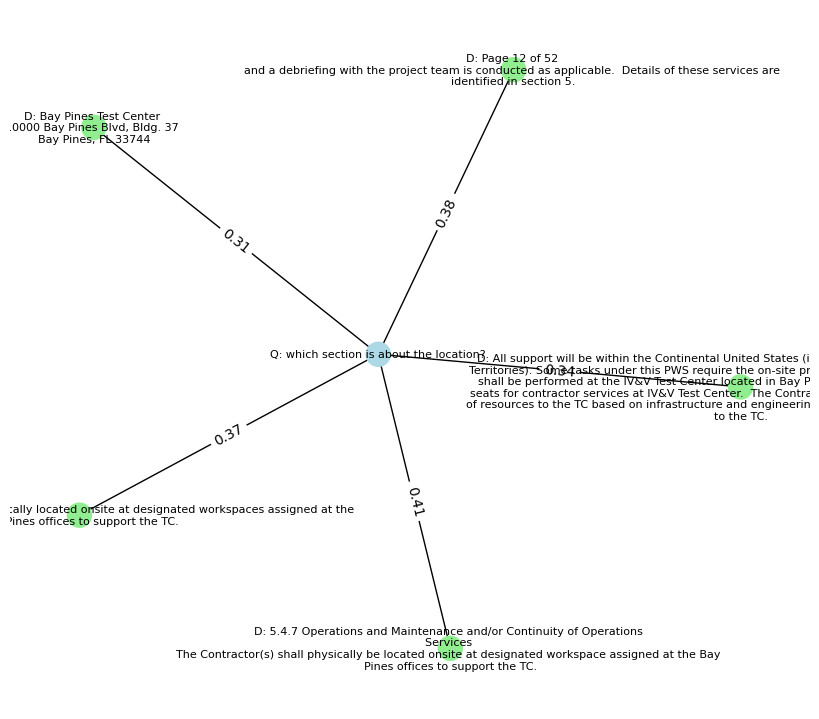

In [7]:

# Create a graph for top 5 results
for query in queries:
    G = nx.Graph()
    query_embedding = model.encode(query)
    # Compute cosine similarities
    cos_scores = model.similarity(query_embedding, doc_embeddings)[0]
    # Get top 5 results
    top_results = torch.topk(cos_scores, 5)
    # Add top results to graph
    for i in range(len(top_results[0])):
        G.add_node(f"Q: {query}", type='query')
        G.add_node(f"D: {paragraphs[top_results[1][i]]}", type='doc')
        G.add_edge(f"Q: {query}", f"D: {paragraphs[top_results[1][i]]}", weight=top_results[0][i].item())
       
    
    # Plot the graph
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 7))
    nx.draw(G, pos, with_labels=True, node_color=['lightblue' if G.nodes[n]['type'] == 'query' else 'lightgreen' for n in G.nodes], font_size=8)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # round the edge labels to 2 decimal places
    edge_labels = {k: round(v, 2) for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.draw()